# World Happiness Report

The World Happiness Report is an annual landmark survey of the state of global happiness (155 countries). Governments, civil society, organizations, and policymakers use these reports to evaluate the progress and well-being of nations to explain variations in happiness.  The happiness scores, collected from the Gallup World Poll, follow a rating scale of 0 to 10, with 0 being the worst and 10 being the best possible life of the current lives of the respondents. We will explore whether the well-being of the countries – economy, family, health, freedom, trust of the government, and generosity – contributes to their state of happiness and how the scores would compare if they were in Dystopia, a hypothetical country with the world's lowest national averages.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import os

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["font.size"] = 14
sns.set()

## Load and Clean World Happiness Report (2015 - 2019)

In [2]:
whr_2015 = pd.read_csv('../input/world-happiness-report-2015-2020/2015.csv')
whr_2016 = pd.read_csv('../input/world-happiness-report-2015-2020/2016.csv')
whr_2017 = pd.read_csv('../input/world-happiness-report-2015-2020/2017.csv')
whr_2018 = pd.read_csv('../input/world-happiness-report-2015-2020/2018.csv')
whr_2019 = pd.read_csv('../input/world-happiness-report-2015-2020/2019.csv')
# whr_2015.head()

In [3]:
# Display column names of each dataset
col_names = {
    "whr_2015": np.array(whr_2015.columns),
    "whr_2016": np.array(whr_2016.columns),
    "whr_2017": np.array(whr_2017.columns),
    "whr_2018": np.array(whr_2018.columns),
    "whr_2019": np.array(whr_2019.columns)
}
# col_names

In [4]:
# Make columns consistent across all datasets
whr_2015['Year'] = '2015'
whr_2016['Year'] = '2016'
whr_2017['Year'] = '2017'
whr_2018['Year'] = '2018'
whr_2019['Year'] = '2019'

whr_2015 = whr_2015.drop(columns=['Standard Error'])
whr_2016 = whr_2016.drop(columns=['Lower Confidence Interval', 'Upper Confidence Interval'])
whr_2017 = whr_2017.rename(columns={'Happiness.Rank': 'Happiness Rank',
                                    'Happiness.Score': 'Happiness Score',
                                    'Economy..GDP.per.Capita.': 'Economy (GDP per Capita)',
                                    'Health..Life.Expectancy.': 'Health (Life Expectancy)',
                                    'Trust..Government.Corruption.': 'Trust (Government Corruption)',
                                    'Dystopia.Residual': 'Dystopia Residual'}) \
                   .drop(columns=['Whisker.high', 'Whisker.low'])
whr_2018 = whr_2018.rename(columns={'Overall rank': 'Happiness Rank',
                                    'Country or region': 'Country',
                                    'Score': 'Happiness Score',
                                    'GDP per capita': 'Economy (GDP per Capita)',
                                    'Social support': 'Family',
                                    'Healthy life expectancy': 'Health (Life Expectancy)',
                                    'Freedom to make life choices': 'Freedom',
                                    'Perceptions of corruption': 'Trust (Government Corruption)'})
whr_2019 = whr_2019.rename(columns={'Overall rank': 'Happiness Rank',
                                    'Country or region': 'Country',
                                    'Score': 'Happiness Score',
                                    'GDP per capita': 'Economy (GDP per Capita)',
                                    'Social support': 'Family',
                                    'Healthy life expectancy': 'Health (Life Expectancy)',
                                    'Freedom to make life choices': 'Freedom',
                                    'Perceptions of corruption': 'Trust (Government Corruption)'})

In [5]:
# Create one dataframe that contains all of 2015-2019 data
happy = pd.concat([whr_2015, whr_2016, whr_2017, whr_2018, whr_2019], ignore_index=True)
# happy.head()

In [6]:
def region(country):
    """ Get region name based on 2015 dataset """
    try:  # if region name is in 2015 dataset, add name to region column
        region_name = list(whr_2015.loc[whr_2015['Country'] == country]['Region'])[0]
        return region_name
    except IndexError:  # if region name is not in 2015 dataset, add empty string to region column
        return ''
    
happy['Region'] = happy['Country'].apply(region)
non_reg = happy[happy['Country'].isin(whr_2015['Country'].unique()) == False]['Country'].unique().tolist()
print(f'Regions in happy that is not in 2015 dataset: \n{non_reg} ')

Regions in happy that is not in 2015 dataset: 
['Puerto Rico', 'Belize', 'Somalia', 'Somaliland Region', 'Namibia', 'South Sudan', 'Taiwan Province of China', 'Hong Kong S.A.R., China', 'Trinidad & Tobago', 'Northern Cyprus', 'North Macedonia', 'Gambia'] 


In [7]:
# Assign countries with missing regions from 2015 dataset with their regions
def region_name(region, countries):
    for c in countries:
        happy.loc[happy['Country'] == c, 'Region'] = region
        
region_name('Latin America and Caribbean', ['Puerto Rico', 'Belize', 'Trinidad & Tobago'])
region_name('Sub-Saharan Africa',          ['Somalia', 'Somaliland Region', 'Namibia', 'South Sudan', 'Gambia'])
region_name('Eastern Asia',                ['Taiwan Province of China', 'Hong Kong S.A.R., China'])
region_name('Central and Eastern Europe',  ['Northern Cyprus', 'North Macedonia'])

# Replace NaN values with 0 to prevent future problems
happy = happy.fillna(0)

In [8]:
# Save cleaned data to access later
# happy.to_csv('./data/happy.csv')
whr_2015 = pd.read_csv('../input/heppy-data/happy.csv')

In [9]:
happy.std()

Happiness Rank                   45.182384
Happiness Score                   1.127456
Economy (GDP per Capita)          0.407340
Family                            0.329548
Health (Life Expectancy)          0.248309
Freedom                           0.152880
Trust (Government Corruption)     0.105844
Generosity                        0.122321
Dystopia Residual                 1.115230
dtype: float64

In [10]:
# Standardized happy dataframe
happy_su = (happy - happy.drop(['Year'], axis=1).mean()) / happy.std()
happy_su = happy_su.drop(['Country', 'Region', 'Year'], axis=1) \
                   .merge(happy[['Country', 'Region', 'Year']], 
                          left_index=True, right_index=True) \
                   [happy.columns]
# happy_su.to_csv('./data/happy_su.csv')
whr_2015 = pd.read_csv('../input/heppy-data/happy_su.csv')

## Exploratory Data Analysis (EDA)

### Which countries have the highest Happiness Score?

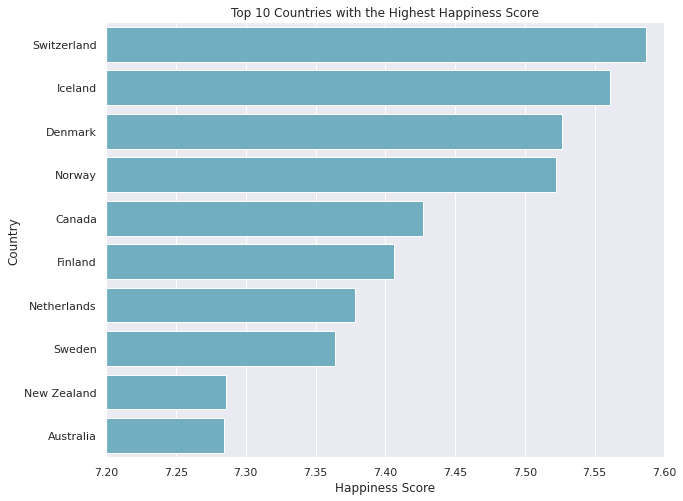

In [11]:
sns.barplot(x='Happiness Score', y='Country', 
            data=happy[:10].sort_values('Happiness Score', ascending=False), 
            orient='h', color='c');
plt.title('Top 10 Countries with the Highest Happiness Score');
plt.xlim(7.2, 7.6);

### Which regions have the highest Happiness Score?

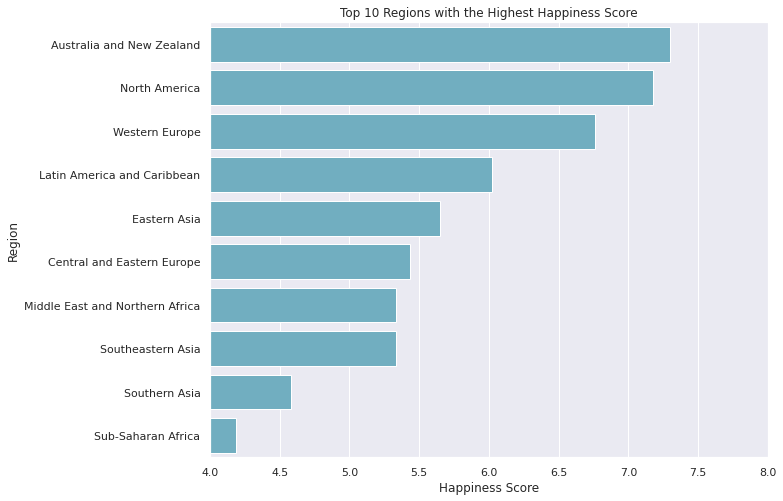

In [12]:
sns.barplot(x='Happiness Score', y='Region', 
            data=happy.groupby('Region', as_index=False).mean().sort_values('Happiness Score', ascending=False),
            orient='h', color='c');
plt.title('Top 10 Regions with the Highest Happiness Score');
plt.xlim(4, 8);

Europe, North America, Australia, and New Zealand seem to have the highest Happiness Scores, likely from their economic development and social structure. These countries or regions tend to be well-developed with sufficient housing, education, healthcare, and other basic needs. Residents usually have well-paying jobs to live comfortably.

### Correlation Matrix
The correlation matrix for all countries below indicates a strong correlation between happiness rank/score and the economy and health. There is a slightly weaker correlation for family and freedom and a weak correlation for trust, generosity, and dystopia residual. However, each country or region is different. Further below, there is a comparison between Western Europe, Eastern Asia, North America, and the Middle East and Northern Africa. Each determining factor of a region's happiness rank/score is weighted differently. For instance, trust in government seems to be the most correlated for Western Europe and North America, while the economy is the most correlated for the other two regions.

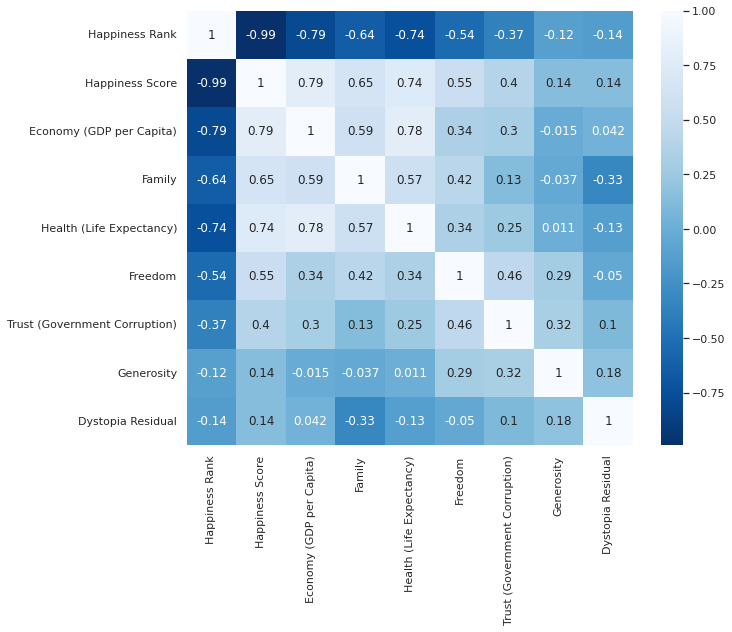

In [13]:
# Overall Correlation
sns.heatmap(happy.corr(), cmap='Blues_r', annot=True);

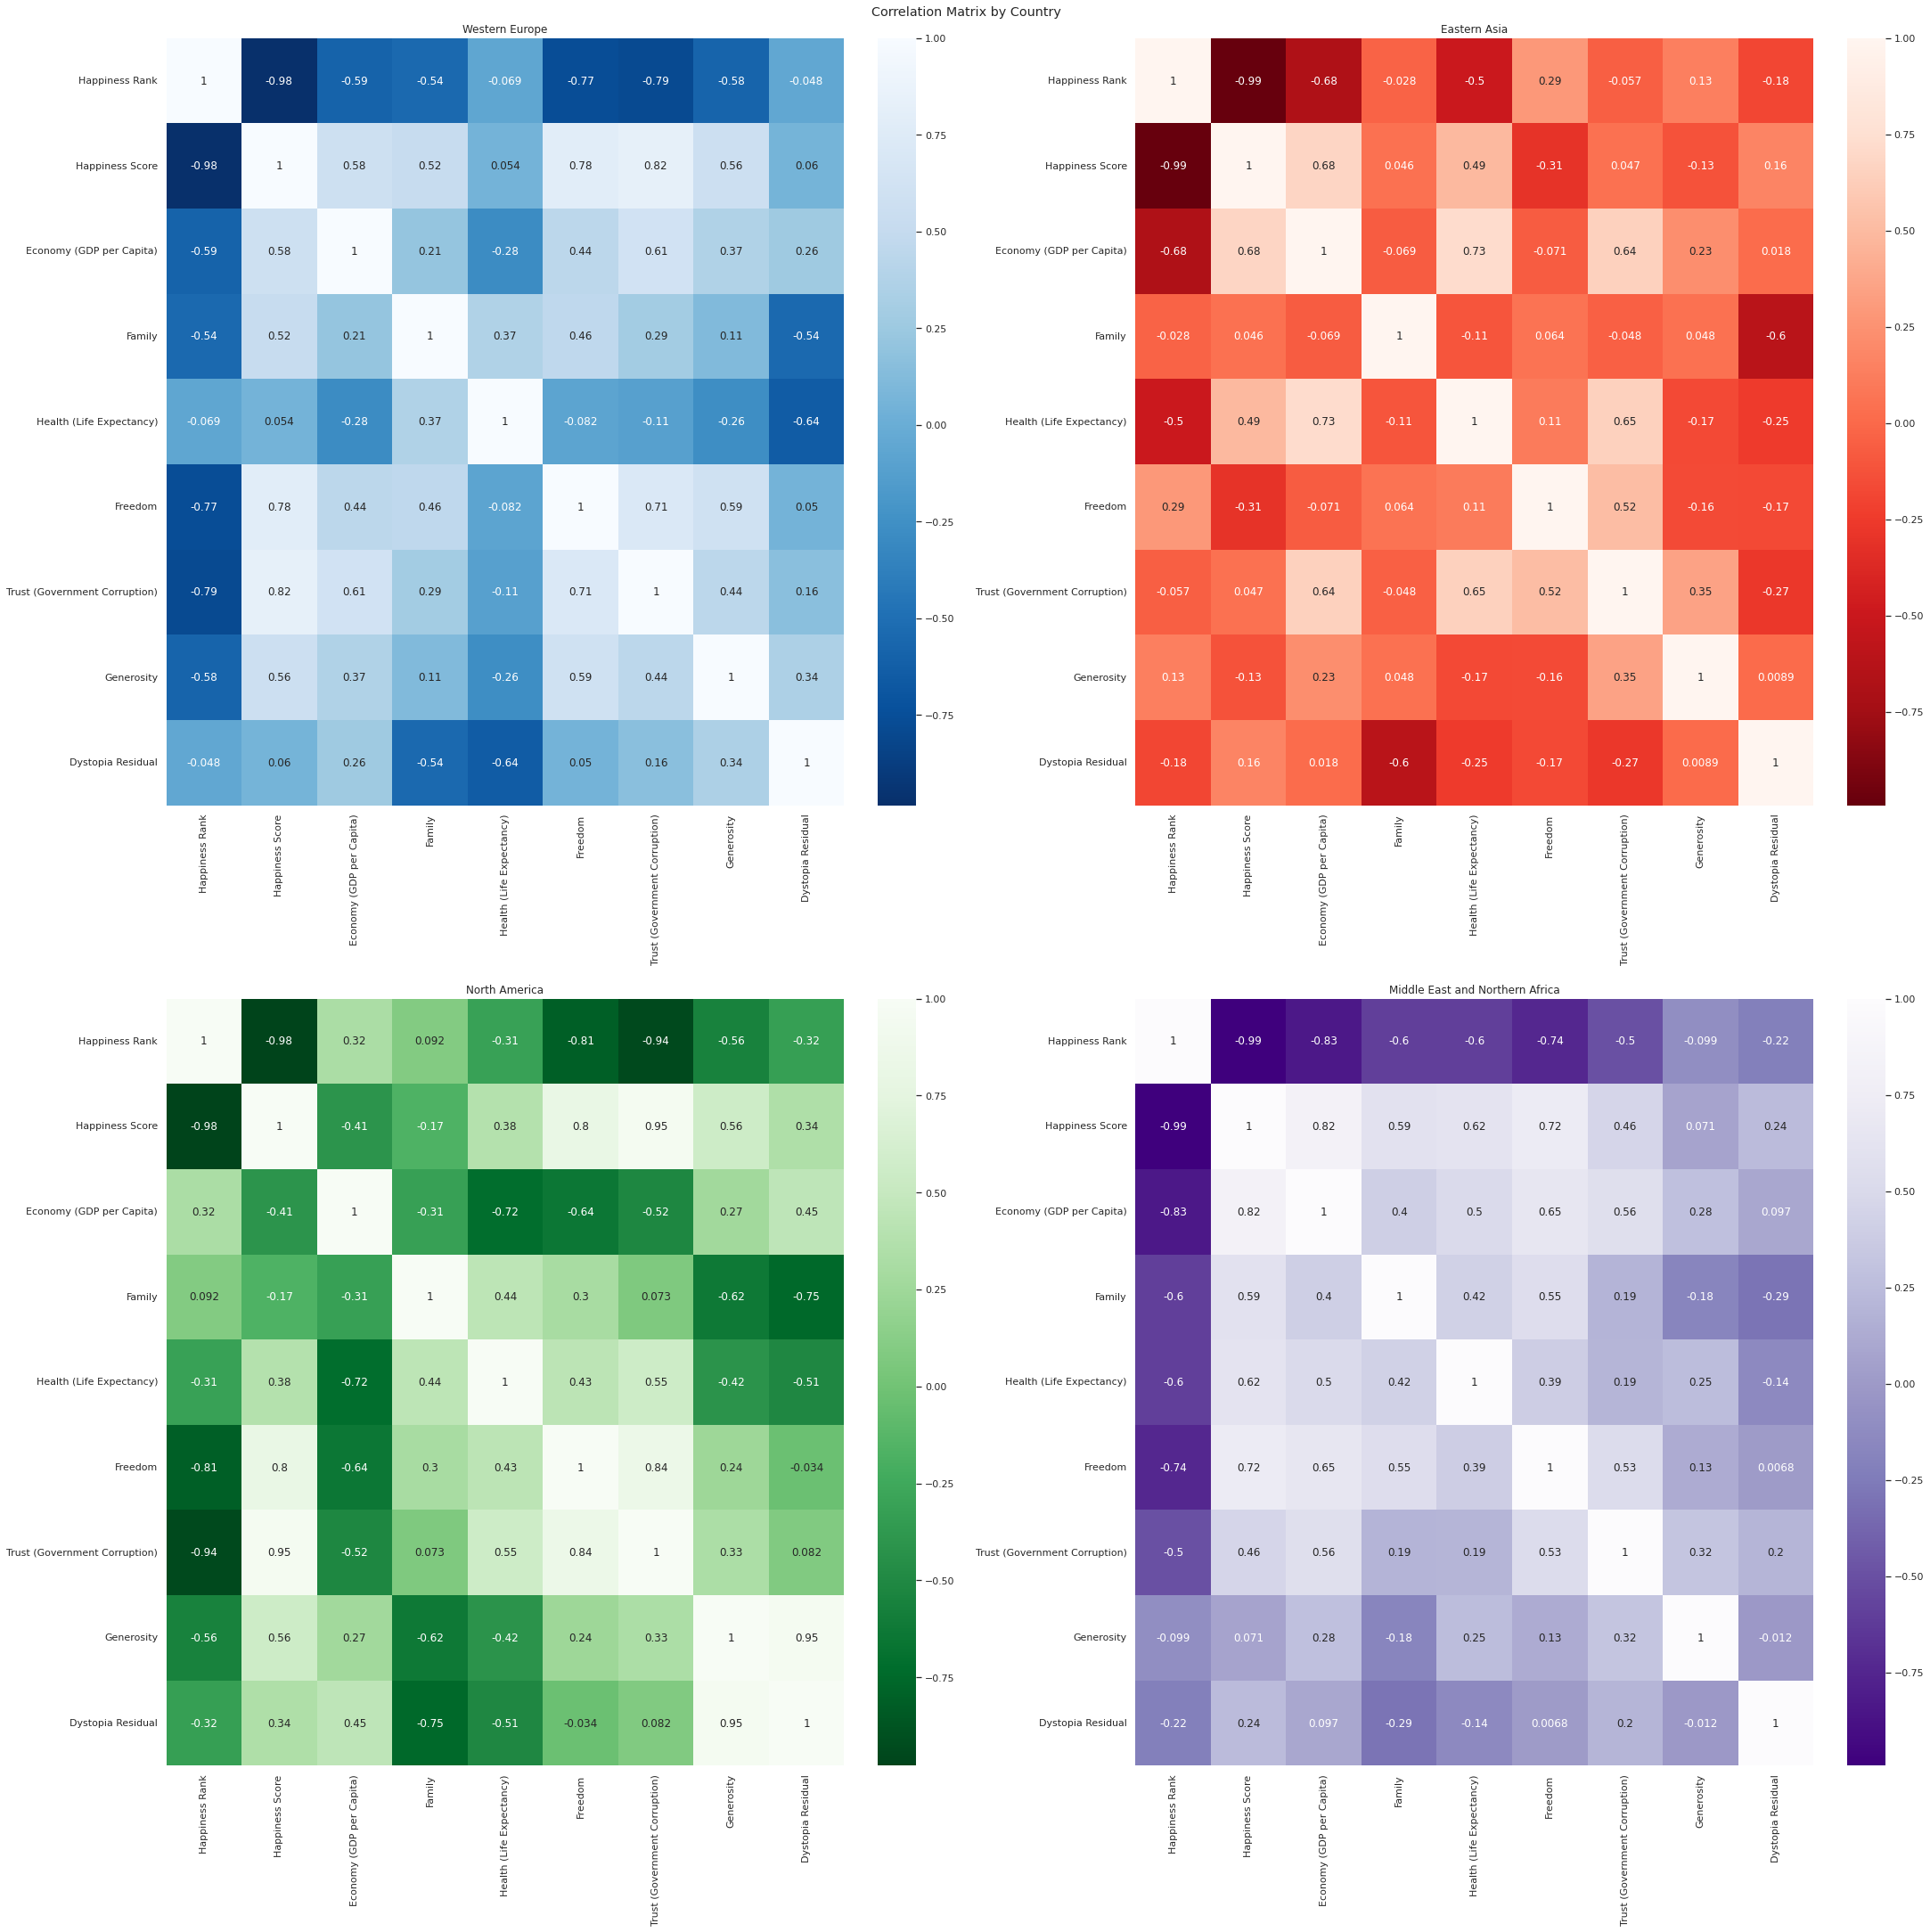

In [14]:
# Correlation by Region
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(30, 30), constrained_layout=True)
sns.heatmap(happy[happy['Region'] == 'Western Europe'].corr(), cmap='Blues_r', annot=True, ax=axs[0, 0]);
axs[0, 0].set_title('Western Europe');
sns.heatmap(happy[happy['Region'] == 'Eastern Asia'].corr(), cmap='Reds_r', annot=True, ax=axs[0, 1]);
axs[0, 1].set_title('Eastern Asia');
sns.heatmap(happy[happy['Region'] == 'North America'].corr(), cmap='Greens_r', annot=True, ax=axs[1, 0]);
axs[1, 0].set_title('North America');
sns.heatmap(happy[happy['Region'] == 'Middle East and Northern Africa'].corr(), cmap='Purples_r', annot=True, ax=axs[1, 1]);
axs[1, 1].set_title('Middle East and Northern Africa');
fig.suptitle('Correlation Matrix by Country');

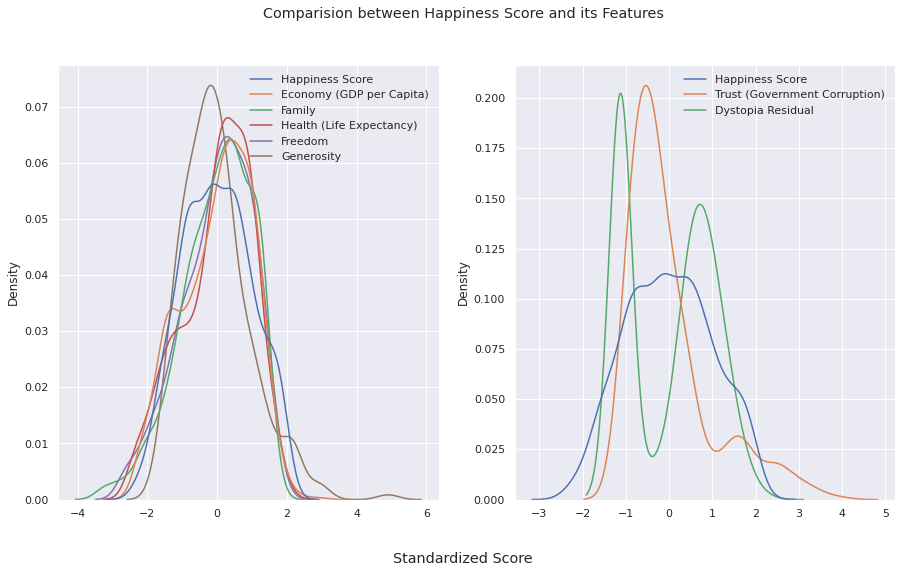

In [15]:
# KDE Plot: distrubition of each factor
fig, axs = plt.subplots(ncols=2, figsize=(15, 8))
# Stronger Correlation
sns.kdeplot(data=happy_su.drop(columns=['Happiness Rank', 'Trust (Government Corruption)', 'Dystopia Residual']), ax=axs[0]);
# Weaker Correlation
sns.kdeplot(data=happy_su[['Happiness Score', 'Trust (Government Corruption)', 'Dystopia Residual']], ax=axs[1]);
fig.suptitle('Comparision between Happiness Score and its Features');
fig.supxlabel('Standardized Score');

### Top 20 Happiness Ranks (2015 - 2019)

In [16]:
fig = px.scatter(happy[happy['Happiness Rank'] <= 20], x="Happiness Rank", y="Happiness Score", 
                 color="Year", title='Top 20 Happiness Ranks from 2015 to 2019', 
                 hover_data={'Country': True,
                             'Happiness Rank':False})
fig.show()

![Scatter](https://raw.githubusercontent.com/eugpoon/happy/main/image/scatter.png)

#### Plot a Feature

In [17]:
feature = 'Family'

fig = px.choropleth(happy, locations='Country', locationmode='country names',
                    color=feature, color_continuous_scale='Ice', animation_frame='Year',
                    hover_name='Country', hover_data=['Happiness Rank', 'Happiness Score'],
                    title=f'{feature} Changes')

# fig["layout"].pop("updatemenus") # drop animation buttons
fig.show()

![Map](https://raw.githubusercontent.com/eugpoon/happy/main/image/map.png)

#### Plot Multiple Features
Countries with a better economy and higher health or life expectancy seem to have higher happiness scores.

In [18]:
x_col = 'Economy (GDP per Capita)'
y_col = 'Health (Life Expectancy)'
fig = px.scatter(happy, x=x_col, y=y_col, 
                 animation_frame='Year', animation_group='Country',
                 size=(happy['Happiness Score'])**3, color='Region', size_max=15,
                 hover_name='Country', hover_data=['Happiness Rank', 'Happiness Score'],
                 title=f'Happiness Change ({x_col} and {y_col})')

# fig["layout"].pop("updatemenus") # drop animation buttons
fig.show()

![Bubble](https://raw.githubusercontent.com/eugpoon/happy/main/image/bubble.png)

#### Identify Outliers
Countries with low happiness scores tend to be outliers.

In [19]:
z_score = np.abs(stats.zscore(happy['Happiness Score'])) > 2
happy_out = happy[z_score]
happy_out.head(2)

,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
155,Syria,Middle East and Northern Africa,156,3.006,0.6632,0.47489,0.72193,0.15684,0.18906,0.47179,0.32858,2015
156,Burundi,Sub-Saharan Africa,157,2.905,0.0153,0.41587,0.22396,0.11850,0.10062,0.19727,1.83302,2015


[Mahalanobis Distance](https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3): find outliers for multiple variables

In [20]:
from scipy.spatial import distance
from scipy.stats import chi2

feat1 = 'Happiness Score'
feat2 = 'Freedom'

isolated_happy = happy.loc[happy['Year'] == '2019'][[feat1, feat2]]

centerpoint = np.mean(isolated_happy)
print("Centerpoints:")
print(centerpoint)


covariance = np.cov(isolated_happy, rowvar=False)
covaraince_inv = np.linalg.matrix_power(covariance, -1)

lambda_, v = np.linalg.eig(covariance)
lambda_ = np.sqrt(lambda_)

feature_tuples = zip(isolated_happy[feat1], isolated_happy[feat2])
distances = []
for feature_pair in feature_tuples:
    distances.append(distance.mahalanobis(feature_pair, centerpoint, covaraince_inv))
distances = np.array(distances)

# Outliers from Chi-Sqaure
cutoff = chi2.ppf(0.95, isolated_happy.shape[1]) / 2.5
outlierIndexes = np.where(distances > cutoff )
# happy.loc[happy['Year'] == '2019'].iloc[outlierIndexes].head(2)

Centerpoints:
Happiness Score    5.407096
Freedom            0.392571
dtype: float64


In [21]:
data = go.Scatter(x = isolated_happy[feat1],
                  y = isolated_happy[feat2],
                  mode = "markers",
                  name = "2019",
                  marker = dict(color = 'blue'),
                  text= happy.loc[happy['Year'] == '2019'].Country)
layout = dict(title = 'Outliers of Happiness Score and Freedom (2019)',
              xaxis= dict(title= feat1,ticklen= 5,zeroline= False),
              yaxis= dict(title= feat2,ticklen= 5,zeroline= False),
              hovermode="x"
             )
fig = go.Figure(data = data, layout = layout)

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=centerpoint[0]-lambda_[0]*np.sqrt(cutoff)*np.sqrt(2.5), y0=centerpoint[1]-lambda_[1]*np.sqrt(cutoff)*np.sqrt(2.5),
    x1=centerpoint[0]+lambda_[0]*np.sqrt(cutoff)*np.sqrt(2.5), y1=centerpoint[1]+lambda_[1]*np.sqrt(cutoff)*np.sqrt(2.5),
    opacity=0.2,
    fillcolor="blue",
    line_color="blue",
)

iplot(fig)

![Outlier](https://raw.githubusercontent.com/eugpoon/happy/main/image/outlier.png)

### Distribution of Happiness Score for Each Region

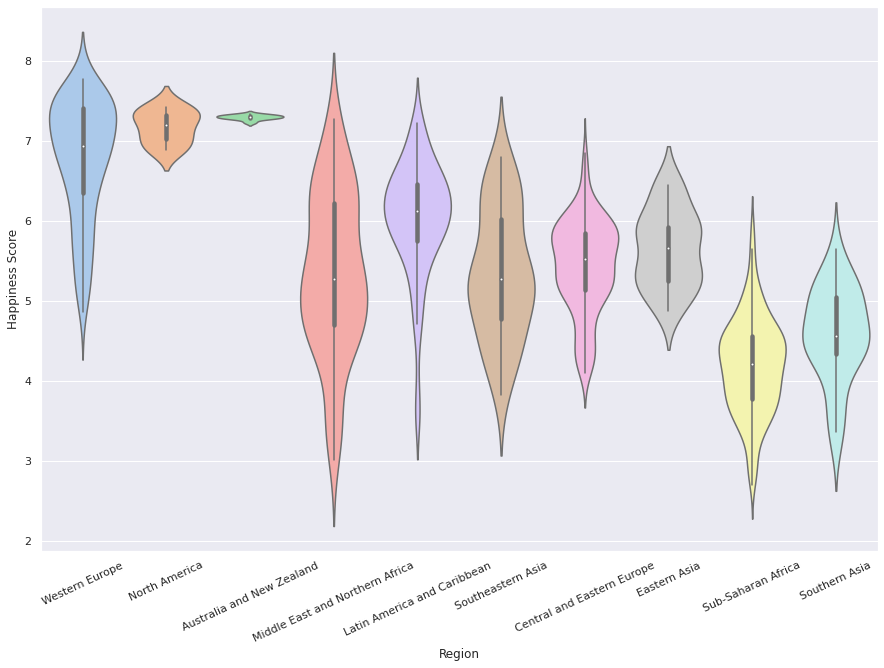

In [22]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.violinplot(data=happy, y='Happiness Score', x='Region', scale='width', palette='pastel');
plt.xticks(rotation=25);

## Top 10 Generous Countries

In [23]:
happy.groupby('Country', as_index=False).max().sort_values(by='Generosity', ascending=False).head(10)[['Country', 'Generosity']]

,Country,Generosity
100,Myanmar,0.838075
63,Indonesia,0.611705
151,Thailand,0.586960
91,Malta,0.574731
161,United Kingdom,0.519120
134,Somaliland Region,0.514790
135,Somaliland region,0.503180
104,New Zealand,0.500005
146,Syria,0.493664
140,Sri Lanka,0.490864


# Top 10 Countries with Trust in Governance

In [24]:
happy.groupby('Country', as_index=False).max().sort_values(by='Trust (Government Corruption)', ascending=False).head(10)[['Country', 'Trust (Government Corruption)']]

,Country,Trust (Government Corruption)
125,Rwanda,0.55191
122,Qatar,0.52208
130,Singapore,0.49210
38,Denmark,0.48357
144,Sweden,0.43844
104,New Zealand,0.42922
145,Switzerland,0.41978
46,Finland,0.41372
135,Somaliland region,0.39928
160,United Arab Emirates,0.38583


# Top 10 Happiest Countries

In [25]:
happy.groupby('Country', as_index=False).max().sort_values(by='Happiness Score', ascending=False).head(10)[['Country', 'Happiness Score']]

,Country,Happiness Score
46,Finland,7.769
38,Denmark,7.600
111,Norway,7.594
145,Switzerland,7.587
61,Iceland,7.561
103,Netherlands,7.488
25,Canada,7.427
144,Sweden,7.364
104,New Zealand,7.334
6,Australia,7.313
